In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:


# === Set the shared path and load data set ===
base_path = r'G:\csv_outputs'
df_combined = pd.read_csv(f"{base_path}\\Combined_4Condition_Cleaned.csv")

# === Optional: print shapes for quick verification ===
print(f"Combined shape: {df_combined.shape}")

Combined shape: (159, 62)


In [3]:
from sklearn.model_selection import train_test_split
# === STEP 1: Prepare features and labels ===
X = df_combined.drop(columns=['Subject_ID', 'Label'])
y = df_combined['Label']
subject_ids = df_combined['Subject_ID']

# === STEP 2: Train-test split (keep test untouched)
X_train, X_test, y_train, y_test, ids_train, ids_test = train_test_split(
    X, y, subject_ids, test_size=0.2, stratify=y, random_state=42
)

# pipeline (scaler > RF > Elastic)

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# === Stratified K-Fold ===
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# === Feature Selector with Random Forest (top 16) ===
rf_selector = SelectFromModel(
    RandomForestClassifier(n_estimators=100, random_state=42),
    threshold=-np.inf, max_features=16
)

# === ElasticNet Logistic Regression Base ===
elastic_model = LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    max_iter=10000
)

# === Pipeline: Scaling + RF Feature Selection + ElasticNet Logistic Regression ===
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_select', rf_selector),
    ('lr', elastic_model)
])

# === Parameter Grid for Logistic Regression ===
param_grid = {
    'lr__C': np.logspace(-2, 1, 5),
    'lr__l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'lr__class_weight': [None,'balanced'],
}

# === Grid SearchCV ===
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring={
        'accuracy': 'accuracy',
        'precision_macro': 'precision_macro',
        'recall_macro': 'recall_macro',
        'f1_macro': 'f1_macro',
        'roc_auc': 'roc_auc'
    },
    refit='f1_macro',
    cv=cv,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# === Fit ===
grid.fit(X_train, y_train)
print("✅ Best Params:", grid.best_params_)

# === Train Metrics ===
y_pred = grid.predict(X_train)
y_proba = grid.predict_proba(X_train)[:, 1]

print("📘 Classification Report (Train):")
print(classification_report(y_train, y_pred, target_names=['Control', 'ADHD']))
print("ROC AUC:", roc_auc_score(y_train, y_proba))

# === Plots ===
RocCurveDisplay.from_predictions(y_train, y_proba)
plt.title("ROC Curve — Train Set")
plt.tight_layout()
plt.show()

PrecisionRecallDisplay.from_predictions(y_train, y_proba)
plt.title("Precision-Recall Curve — Train Set")
plt.tight_layout()
plt.show()

# === Cross-Validated Generalization ===
cv_scores = cross_validate(
    grid.best_estimator_,
    X_train, y_train,
    scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc'],
    cv=cv,
    return_train_score=True
)

print("\n📊 Cross-Validated Scores:")
for k, v in cv_scores.items():
    print(f"{k}: {np.mean(v):.4f}")

# === Show Top 16 Feature Importances ===
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

importances = rf_model.feature_importances_
feature_names = X_train.columns if isinstance(X_train, pd.DataFrame) else [f"Feature_{i}" for i in range(X_train.shape[1])]
top_20_idx = np.argsort(importances)[::-1][:20]
top_features = pd.DataFrame({
    'Feature': np.array(feature_names)[top_20_idx],
    'Importance': importances[top_20_idx]
}).sort_values(by='Importance', ascending=False)

print("\n🌟 Top 16 Features by Importance:")
print(top_features)


Fitting 10 folds for each of 110 candidates, totalling 1100 fits


KeyboardInterrupt: 

# pipeline (Rf > Scaler > Elastic)

Fitting 10 folds for each of 110 candidates, totalling 1100 fits
✅ Best Params: {'lr__C': 0.46415888336127775, 'lr__class_weight': None, 'lr__l1_ratio': 0.8}
📘 Classification Report (Train):
              precision    recall  f1-score   support

     Control       0.82      0.98      0.90        96
        ADHD       0.85      0.35      0.50        31

    accuracy                           0.83       127
   macro avg       0.84      0.67      0.70       127
weighted avg       0.83      0.83      0.80       127

ROC AUC (Train): 0.8508064516129031


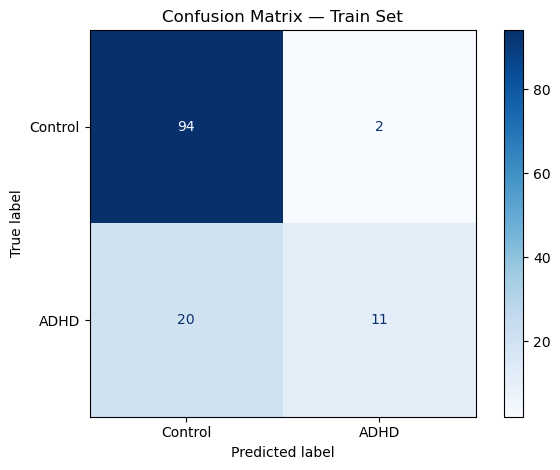

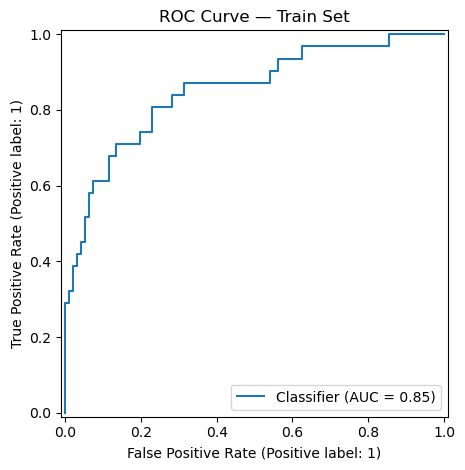

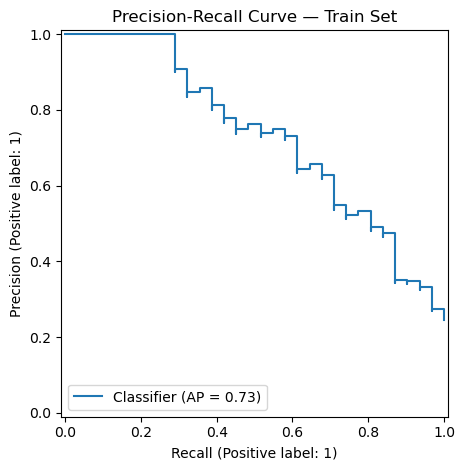

e:\anaconda\envs\basic\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\anaconda\envs\basic\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



📊 Cross-Validated Scores:
fit_time: 0.2780
score_time: 0.0418
test_accuracy: 0.7554
train_accuracy: 0.8183
test_precision_macro: 0.5905
train_precision_macro: 0.7979
test_recall_macro: 0.5625
train_recall_macro: 0.6671
test_f1_macro: 0.5476
train_f1_macro: 0.6941
test_roc_auc: 0.6750
train_roc_auc: 0.8564

📘 Classification Report (Test):
              precision    recall  f1-score   support

     Control       0.79      0.96      0.87        24
        ADHD       0.67      0.25      0.36         8

    accuracy                           0.78        32
   macro avg       0.73      0.60      0.62        32
weighted avg       0.76      0.78      0.74        32

ROC AUC (Test): 0.8020833333333333


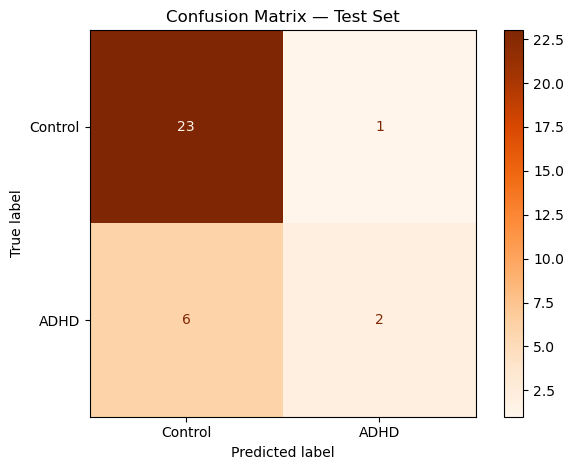

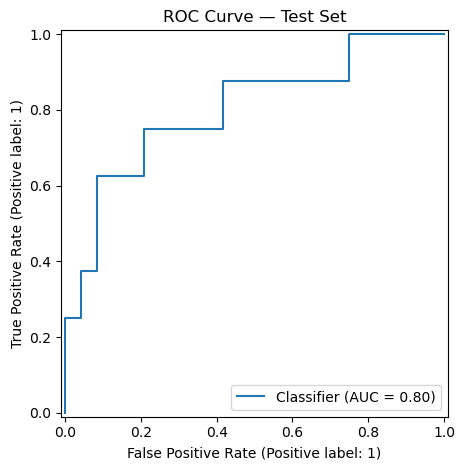

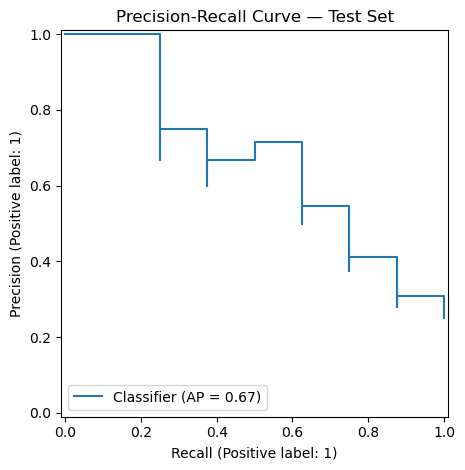

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay)

# === Stratified K-Fold ===
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# === Feature Selector with Random Forest (on raw features) ===
rf_selector = SelectFromModel(
    estimator=RandomForestClassifier(n_estimators=100, random_state=42),
    threshold=-np.inf,
    max_features=20
)

# === ElasticNet Logistic Regression ===
elastic_model = LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    max_iter=10000
)

# === Pipeline: Raw -> RF selector -> Scaler -> LogisticRegression ===
pipeline = Pipeline([
    ('feature_select', rf_selector),
    ('scaler', StandardScaler()),
    ('lr', elastic_model)
])

# === Param Grid ===
param_grid = {
    'lr__C': np.logspace(-3, 1, 10),
    'lr__l1_ratio': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
    'lr__class_weight': [None]
}

# === Grid SearchCV ===
grid_p = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring={
        'accuracy': 'accuracy',
        'precision_macro': 'precision_macro',
        'recall_macro': 'recall_macro',
        'f1_macro': 'f1_macro',
        'roc_auc': 'roc_auc'
    },
    refit='f1_macro',
    cv=cv,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# === Fit Model ===
grid_p.fit(X_train, y_train)
print("✅ Best Params:", grid_p.best_params_)

# === Train Predictions ===
y_train_pred = grid_p.predict(X_train)
y_train_proba = grid_p.predict_proba(X_train)[:, 1]

# === Evaluation Metrics (Train) ===
print("📘 Classification Report (Train):")
print(classification_report(y_train, y_train_pred, target_names=['Control', 'ADHD']))
print("ROC AUC (Train):", roc_auc_score(y_train, y_train_proba))

# === Confusion Matrix (Train) ===
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, display_labels=['Control', 'ADHD'], cmap='Blues')
plt.title("Confusion Matrix — Train Set")
plt.tight_layout()
plt.show()

# === ROC Curve (Train) ===
RocCurveDisplay.from_predictions(y_train, y_train_proba)
plt.title("ROC Curve — Train Set")
plt.tight_layout()
plt.show()

# === Precision-Recall Curve (Train) ===
PrecisionRecallDisplay.from_predictions(y_train, y_train_proba)
plt.title("Precision-Recall Curve — Train Set")
plt.tight_layout()
plt.show()

# === Cross-Validated Scores ===
cv_scores = cross_validate(
    grid_p.best_estimator_,
    X, y,
    scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc'],
    cv=cv,
    return_train_score=True
)

print("\n📊 Cross-Validated Scores:")
for k, v in cv_scores.items():
    print(f"{k}: {np.mean(v):.4f}")

# === TEST PREDICTIONS AND EVALUATION ===
y_test_pred = grid_p.predict(X_test)
y_test_proba = grid_p.predict_proba(X_test)[:, 1]

print("\n📘 Classification Report (Test):")
print(classification_report(y_test, y_test_pred, target_names=['Control', 'ADHD']))
print("ROC AUC (Test):", roc_auc_score(y_test, y_test_proba))

# === Confusion Matrix (Test) ===
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, display_labels=['Control', 'ADHD'], cmap='Oranges')
plt.title("Confusion Matrix — Test Set")
plt.tight_layout()
plt.show()

# === ROC Curve (Test) ===
RocCurveDisplay.from_predictions(y_test, y_test_proba)
plt.title("ROC Curve — Test Set")
plt.tight_layout()
plt.show()

# === Precision-Recall Curve (Test) ===
PrecisionRecallDisplay.from_predictions(y_test, y_test_proba)
plt.title("Precision-Recall Curve — Test Set")
plt.tight_layout()
plt.show()


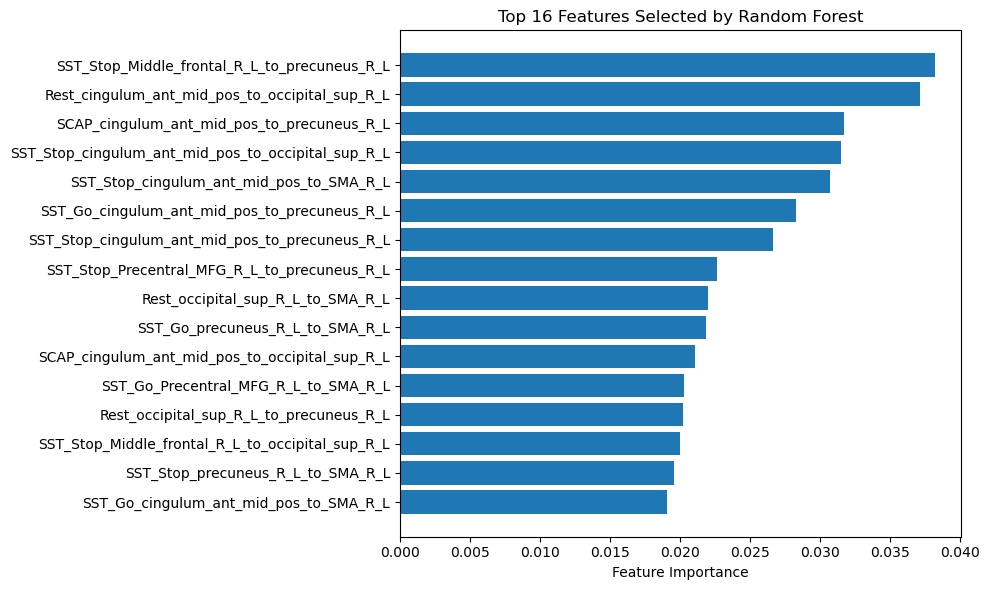

In [14]:
importances = grid_p.best_estimator_.named_steps['feature_select'].estimator_.feature_importances_
selected_mask = grid_p.best_estimator_.named_steps['feature_select'].get_support()

# Get feature names of all features in X_train (assuming X_train is a DataFrame)
feature_names = X_train.columns

# Features selected by the selector
selected_features = feature_names[selected_mask]

# Importances of selected features
selected_importances = importances[selected_mask]

# Create DataFrame for sorting and plotting
feat_imp_df = pd.DataFrame({
    'feature': selected_features,
    'importance': selected_importances
})

# Sort by importance descending
feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False).head(16)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df['feature'][::-1], feat_imp_df['importance'][::-1])
plt.xlabel('Feature Importance')
plt.title('Top 16 Features Selected by Random Forest')
plt.tight_layout()
plt.show()


                                              feature  coefficient
11           SST_Stop_cingulum_ant_mid_pos_to_SMA_R_L    -0.697637
15                  SST_Stop_precuneus_R_L_to_SMA_R_L    -0.586662
13       SST_Stop_Middle_frontal_R_L_to_precuneus_R_L    -0.510066
7                SST_Go_Precentral_MFG_R_L_to_SMA_R_L    -0.458619
3      SCAP_cingulum_ant_mid_pos_to_occipital_sup_R_L    -0.089650
2                   Rest_occipital_sup_R_L_to_SMA_R_L    -0.089136
14       SST_Stop_Precentral_MFG_R_L_to_precuneus_R_L    -0.032453
9   SST_Stop_cingulum_ant_mid_pos_to_occipital_sup...     0.124744
5        SST_Go_cingulum_ant_mid_pos_to_precuneus_R_L     0.155534
1             Rest_occipital_sup_R_L_to_precuneus_R_L     0.171580
12   SST_Stop_Middle_frontal_R_L_to_occipital_sup_R_L     0.372809
10     SST_Stop_cingulum_ant_mid_pos_to_precuneus_R_L     0.453251
0      Rest_cingulum_ant_mid_pos_to_occipital_sup_R_L     0.520147
4          SCAP_cingulum_ant_mid_pos_to_precuneus_R_L     0.55

<Figure size 1000x600 with 0 Axes>

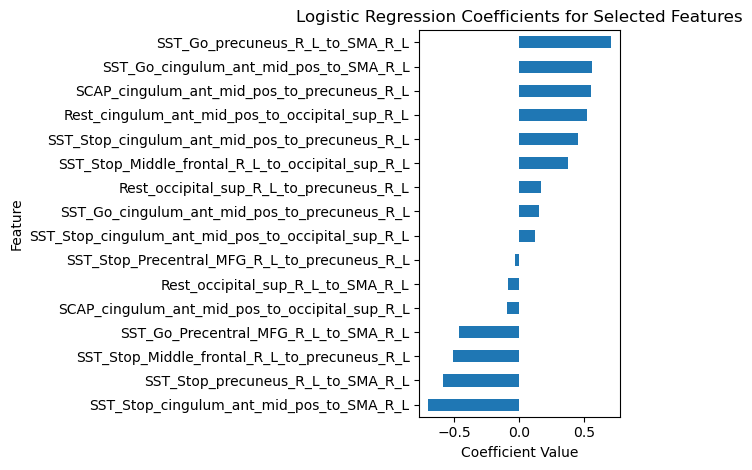

In [23]:
# Get best estimator pipeline
best_pipeline = grid_p.best_estimator_

# Get mask of selected features from SelectFromModel
selected_mask = best_pipeline.named_steps['feature_select'].get_support()

# Get selected feature names
selected_features = X_train.columns[selected_mask]

# Get logistic regression coefficients
lr_coefs = best_pipeline.named_steps['lr'].coef_.flatten()

coef_df = pd.DataFrame({
    'feature': selected_features,
    'coefficient': lr_coefs
}).sort_values(by='coefficient')

print(coef_df)

# Plot coefficients
plt.figure(figsize=(10,6))
coef_df.plot.barh(x='feature', y='coefficient', legend=False)
plt.title("Logistic Regression Coefficients for Selected Features")
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


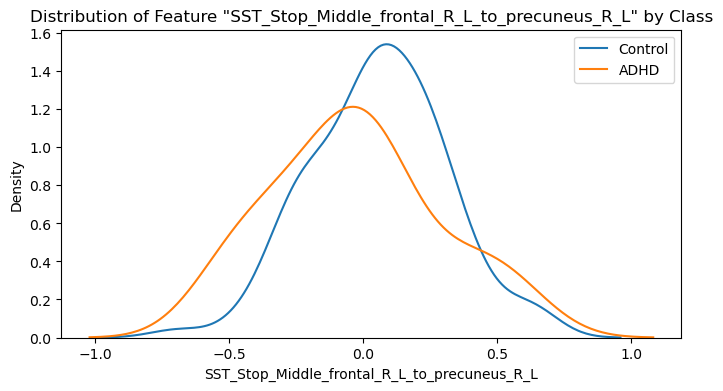

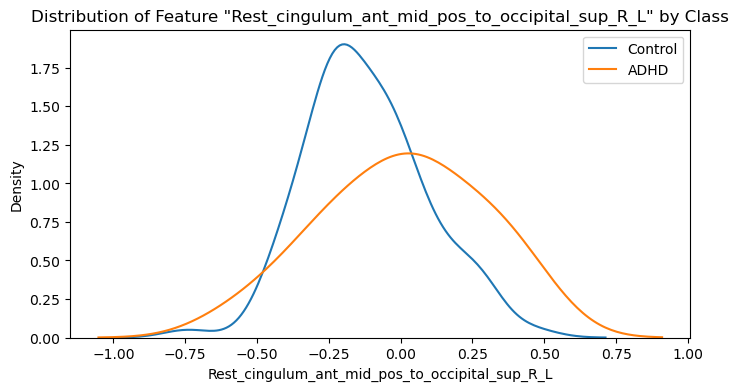

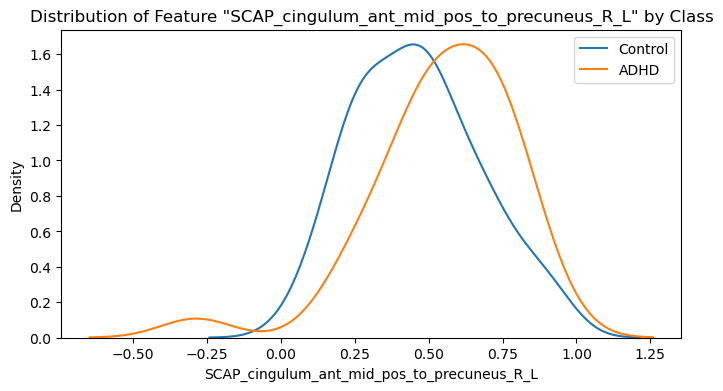

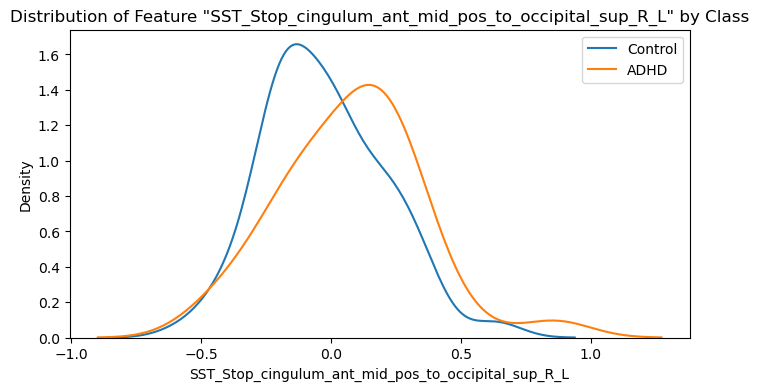

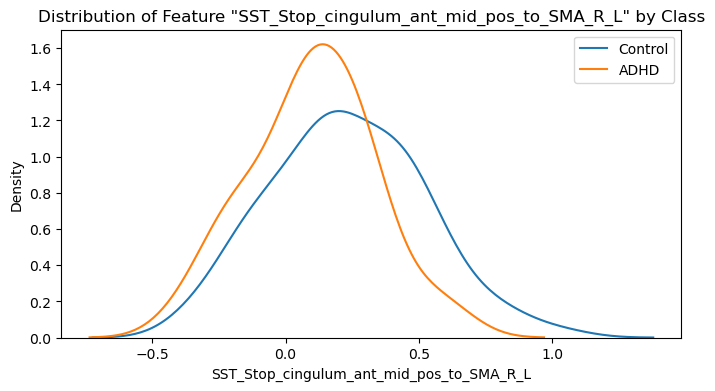

In [15]:
import seaborn as sns

top_features = feat_imp_df['feature'][:5]  # top 5 features

for feat in top_features:
    plt.figure(figsize=(8,4))
    sns.kdeplot(X_train.loc[y_train==0, feat], label='Control')
    sns.kdeplot(X_train.loc[y_train==1, feat], label='ADHD')
    plt.title(f'Distribution of Feature "{feat}" by Class')
    plt.xlabel(feat)
    plt.ylabel('Density')
    plt.legend()
    plt.show()


In [16]:
corr_matrix = X_train.corr()
# Check pairs with very high correlation (>|0.9|)
high_corr = [(col1, col2, corr_matrix.loc[col1, col2]) 
             for col1 in corr_matrix.columns for col2 in corr_matrix.columns 
             if col1 != col2 and abs(corr_matrix.loc[col1, col2]) > 0.9]

print("Highly correlated feature pairs (>0.9):")
for c in high_corr:
    print(c)


Highly correlated feature pairs (>0.9):


# pipeline (Rf > Scaler > bagging(Elastic))

Fitting 10 folds for each of 70 candidates, totalling 700 fits
✅ Best Params: {'lr__estimator__C': 0.01, 'lr__estimator__class_weight': 'balanced', 'lr__estimator__l1_ratio': 0.1}
📘 Classification Report (Train):
              precision    recall  f1-score   support

     Control       0.88      0.68      0.76        96
        ADHD       0.42      0.71      0.52        31

    accuracy                           0.69       127
   macro avg       0.65      0.69      0.64       127
weighted avg       0.77      0.69      0.71       127

ROC AUC (Train): 0.8037634408602151


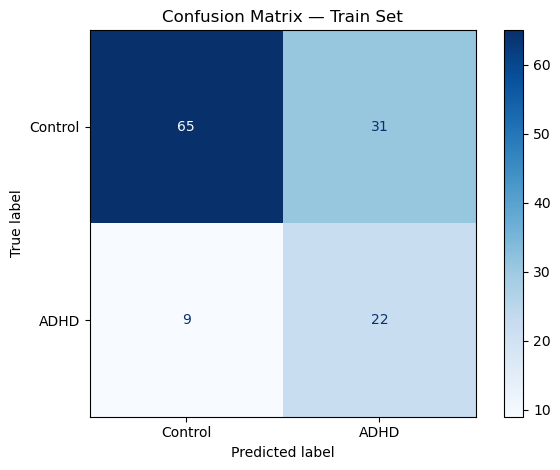

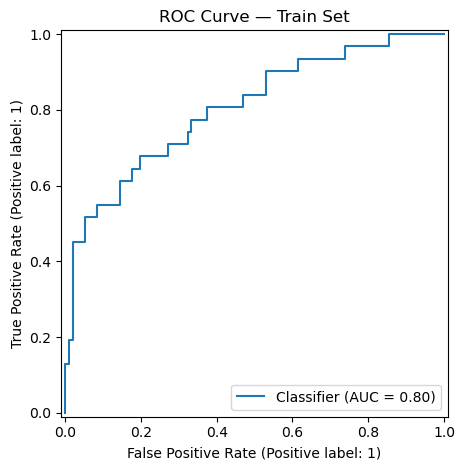

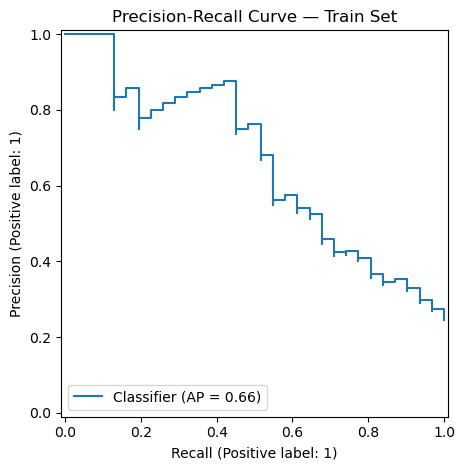


📊 Cross-Validated Scores:
fit_time: 0.6772
score_time: 0.2038
test_accuracy: 0.6513
train_accuracy: 0.7621
test_precision_macro: 0.5896
train_precision_macro: 0.6931
test_recall_macro: 0.5869
train_recall_macro: 0.7127
test_f1_macro: 0.5747
train_f1_macro: 0.6975
test_roc_auc: 0.5837
train_roc_auc: 0.8092

📘 Classification Report (Test):
              precision    recall  f1-score   support

     Control       0.86      0.79      0.83        24
        ADHD       0.50      0.62      0.56         8

    accuracy                           0.75        32
   macro avg       0.68      0.71      0.69        32
weighted avg       0.77      0.75      0.76        32

ROC AUC (Test): 0.828125


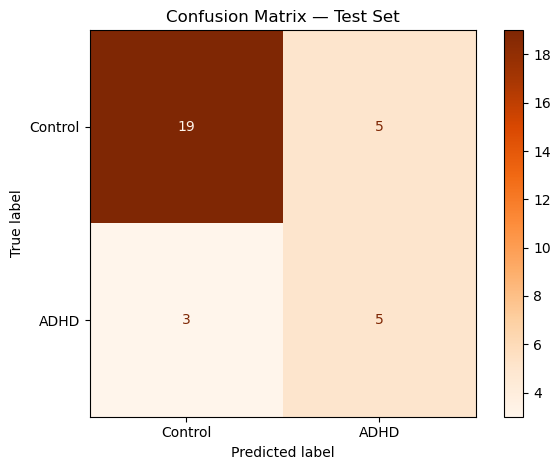

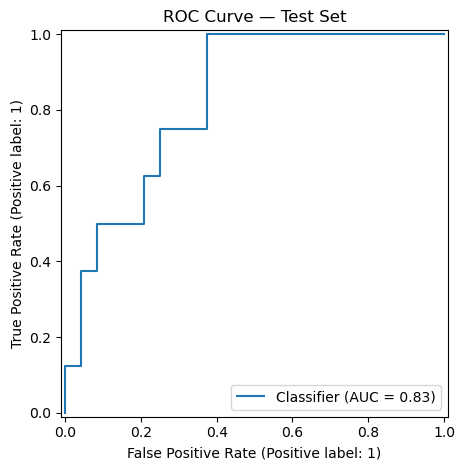

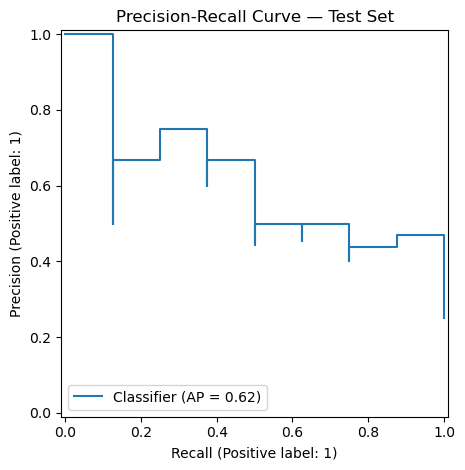

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay)
from sklearn.ensemble import BaggingClassifier

# === Stratified K-Fold ===
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# === Feature Selector with Random Forest (on raw features) ===
rf_selector = SelectFromModel(
    estimator=RandomForestClassifier(n_estimators=100, random_state=42),
    threshold=-np.inf,
    max_features=20
)

# === ElasticNet Logistic Regression ===

elastic_base_model = LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    max_iter=10000
)

# ✅ Wrap it in BaggingClassifier
elastic_model = BaggingClassifier(
    estimator=elastic_base_model,
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)

# === Pipeline: Raw -> RF selector -> Scaler -> LogisticRegression ===
pipeline = Pipeline([
    ('feature_select', rf_selector),
    ('scaler', StandardScaler()),
    ('lr', elastic_model)
])

# === Param Grid ===
param_grid = {
    'lr__estimator__C': np.logspace(-3, 1, 5),
    'lr__estimator__l1_ratio': [0, 0.1,  0.3, 0.5, 0.7,  0.9, 1],
    'lr__estimator__class_weight': [None,'balanced']
}


# === Grid SearchCV ===
grid_p = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring={
        'accuracy': 'accuracy',
        'precision_macro': 'precision_macro',
        'recall_macro': 'recall_macro',
        'f1_macro': 'f1_macro',
        'roc_auc': 'roc_auc'
    },
    refit='f1_macro',
    cv=cv,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# === Fit Model ===
grid_p.fit(X_train, y_train)
print("✅ Best Params:", grid_p.best_params_)

# === Train Predictions ===
y_train_pred = grid_p.predict(X_train)
y_train_proba = grid_p.predict_proba(X_train)[:, 1]

# === Evaluation Metrics (Train) ===
print("📘 Classification Report (Train):")
print(classification_report(y_train, y_train_pred, target_names=['Control', 'ADHD']))
print("ROC AUC (Train):", roc_auc_score(y_train, y_train_proba))

# === Confusion Matrix (Train) ===
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, display_labels=['Control', 'ADHD'], cmap='Blues')
plt.title("Confusion Matrix — Train Set")
plt.tight_layout()
plt.show()

# === ROC Curve (Train) ===
RocCurveDisplay.from_predictions(y_train, y_train_proba)
plt.title("ROC Curve — Train Set")
plt.tight_layout()
plt.show()

# === Precision-Recall Curve (Train) ===
PrecisionRecallDisplay.from_predictions(y_train, y_train_proba)
plt.title("Precision-Recall Curve — Train Set")
plt.tight_layout()
plt.show()

# === Cross-Validated Scores ===
cv_scores = cross_validate(
    grid_p.best_estimator_,
    X_train, y_train,
    scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc'],
    cv=cv,
    return_train_score=True
)

print("\n📊 Cross-Validated Scores:")
for k, v in cv_scores.items():
    print(f"{k}: {np.mean(v):.4f}")

# === TEST PREDICTIONS AND EVALUATION ===
y_test_pred = grid_p.predict(X_test)
y_test_proba = grid_p.predict_proba(X_test)[:, 1]

print("\n📘 Classification Report (Test):")
print(classification_report(y_test, y_test_pred, target_names=['Control', 'ADHD']))
print("ROC AUC (Test):", roc_auc_score(y_test, y_test_proba))

# === Confusion Matrix (Test) ===
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, display_labels=['Control', 'ADHD'], cmap='Oranges')
plt.title("Confusion Matrix — Test Set")
plt.tight_layout()
plt.show()

# === ROC Curve (Test) ===
RocCurveDisplay.from_predictions(y_test, y_test_proba)
plt.title("ROC Curve — Test Set")
plt.tight_layout()
plt.show()

# === Precision-Recall Curve (Test) ===
PrecisionRecallDisplay.from_predictions(y_test, y_test_proba)
plt.title("Precision-Recall Curve — Test Set")
plt.tight_layout()
plt.show()


# Rf > Scaler > Elastic

e:\anaconda\envs\basic\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
e:\anaconda\envs\basic\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Fitting 10 folds for each of 2200 candidates, totalling 22000 fits
✅ Best Params: {'C': 0.23101297000831605, 'class_weight': None, 'l1_ratio': 0}

📘 Classification Report (Train):
              precision    recall  f1-score   support

     Control       0.84      0.97      0.90        96
        ADHD       0.81      0.42      0.55        31

    accuracy                           0.83       127
   macro avg       0.83      0.69      0.73       127
weighted avg       0.83      0.83      0.81       127

ROC AUC: 0.8568548387096775


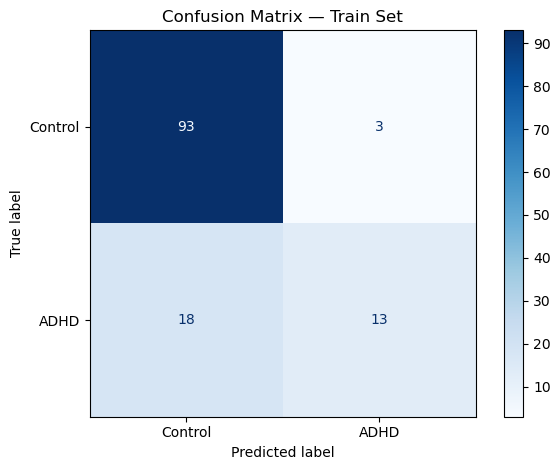

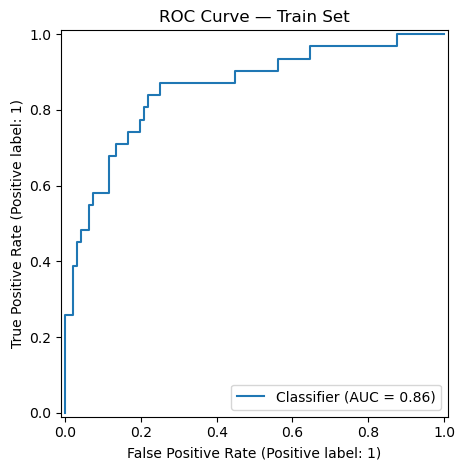

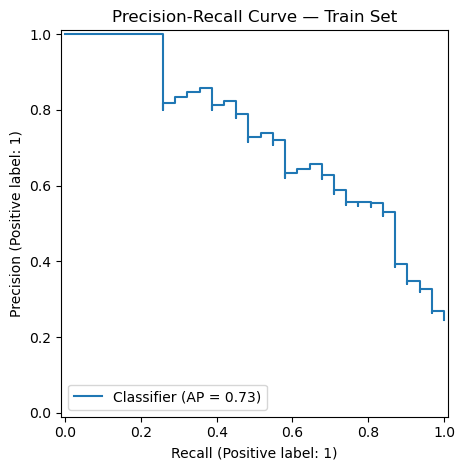

e:\anaconda\envs\basic\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\anaconda\envs\basic\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



📊 Cross-Validated Scores:
fit_time: 0.0028
score_time: 0.0080
test_accuracy: 0.7949
train_accuracy: 0.8347
test_precision_macro: 0.7077
train_precision_macro: 0.8238
test_recall_macro: 0.6411
train_recall_macro: 0.6965
test_f1_macro: 0.6423
train_f1_macro: 0.7269
test_roc_auc: 0.7409
train_roc_auc: 0.8606

📘 Classification Report (Test):
              precision    recall  f1-score   support

     Control       0.79      0.96      0.87        24
        ADHD       0.67      0.25      0.36         8

    accuracy                           0.78        32
   macro avg       0.73      0.60      0.62        32
weighted avg       0.76      0.78      0.74        32

Test ROC AUC: 0.8072916666666667


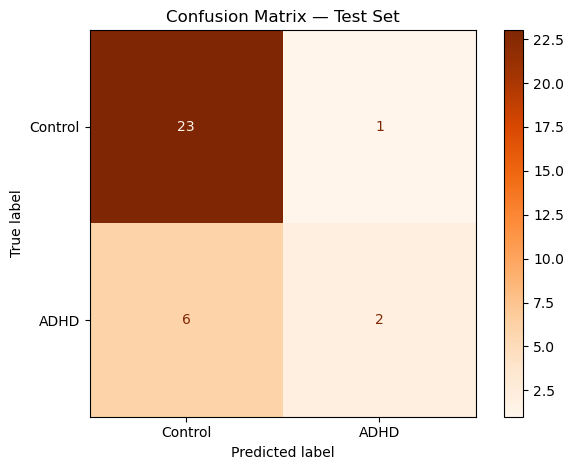

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_validate
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay)

# === Step 1: Feature Selection (Random Forest on raw features) ===
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

selector = SelectFromModel(rf, threshold=-np.inf, max_features=20, prefit=True)
X_train_sel = selector.transform(X_train)
X_test_sel = selector.transform(X_test)

# === Step 2: Scaling ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sel)
X_test_scaled = scaler.transform(X_test_sel)

# === Step 3: Logistic Regression (ElasticNet) ===
elastic = LogisticRegression(penalty='elasticnet', solver='saga', max_iter=10000)

# === Step 4: Grid Search ===
param_grid = {
    'C': np.logspace(-2, 1, 100),
    'l1_ratio': [ 0, 0.1 ,0.2 ,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],
    'class_weight': [None,'balanced'],
}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=elastic,
    param_grid=param_grid,
    scoring={
        'accuracy': 'accuracy',
        'precision_macro': 'precision_macro',
        'recall_macro': 'recall_macro',
        'f1_macro': 'f1_macro',
        'roc_auc': 'roc_auc'
    },
    refit='f1_macro',
    cv=cv,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# === Fit ===
grid.fit(X_train_scaled, y_train)
print("✅ Best Params:", grid.best_params_)

# === Train Set Evaluation ===
y_train_pred = grid.predict(X_train_scaled)
y_train_proba = grid.predict_proba(X_train_scaled)[:, 1]

print("\n📘 Classification Report (Train):")
print(classification_report(y_train, y_train_pred, target_names=['Control', 'ADHD']))
print("ROC AUC:", roc_auc_score(y_train, y_train_proba))

# === Confusion Matrix (Train) ===
cm_train = confusion_matrix(y_train, y_train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=['Control', 'ADHD'])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix — Train Set")
plt.tight_layout()
plt.show()

# === ROC + PR Curves (Train) ===
RocCurveDisplay.from_predictions(y_train, y_train_proba)
plt.title("ROC Curve — Train Set")
plt.tight_layout()
plt.show()

PrecisionRecallDisplay.from_predictions(y_train, y_train_proba)
plt.title("Precision-Recall Curve — Train Set")
plt.tight_layout()
plt.show()

# === Cross-Validation Scores ===
cv_scores = cross_validate(
    grid.best_estimator_,
    X_train_scaled, y_train,
    scoring=['accuracy', 'precision_macro', 'recall_macro', 'f1_macro', 'roc_auc'],
    cv=cv,
    return_train_score=True
)

print("\n📊 Cross-Validated Scores:")
for k, v in cv_scores.items():
    print(f"{k}: {np.mean(v):.4f}")

# === Final Test Set Evaluation (Optional) ===
y_test_pred = grid.predict(X_test_scaled)
y_test_proba = grid.predict_proba(X_test_scaled)[:, 1]

print("\n📘 Classification Report (Test):")
print(classification_report(y_test, y_test_pred, target_names=['Control', 'ADHD']))
print("Test ROC AUC:", roc_auc_score(y_test, y_test_proba))

cm_test = confusion_matrix(y_test, y_test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Control', 'ADHD'])
disp_test.plot(cmap='Oranges', values_format='d')
plt.title("Confusion Matrix — Test Set")
plt.tight_layout()
plt.show()


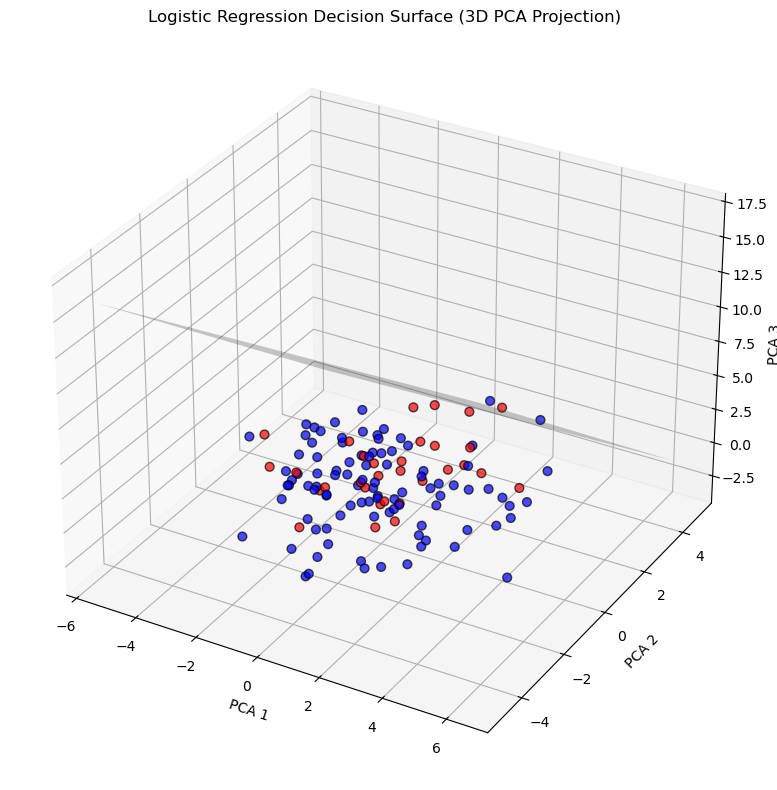

In [22]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

# === Step 1: Apply PCA to reduce to 3 components ===
pca = PCA(n_components=3)
X_train_pca = pca.fit_transform(X_train_scaled)

# === Step 2: Fit logistic regression again on 3D data ===
logreg_pca = LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    max_iter=10000,
    C=grid.best_params_['C'],
    l1_ratio=grid.best_params_['l1_ratio'],
    class_weight=grid.best_params_['class_weight']
)
logreg_pca.fit(X_train_pca, y_train)

# === Step 3: Create meshgrid for plotting decision boundary ===
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
z_min, z_max = X_train_pca[:, 2].min() - 1, X_train_pca[:, 2].max() + 1

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 30),
    np.linspace(y_min, y_max, 30)
)

# Compute decision boundary z = -(b0 + b1*x + b2*y) / b3
coef = logreg_pca.coef_[0]
intercept = logreg_pca.intercept_[0]
zz = -(coef[0] * xx + coef[1] * yy + intercept) / coef[2]

# === Step 4: Plot 3D scatter and decision surface ===
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot training points
colors = ['blue' if label == 0 else 'red' for label in y_train]
ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], X_train_pca[:, 2],
           c=colors, edgecolor='k', s=40, alpha=0.7, label='Train Samples')

# Plot decision surface
ax.plot_surface(xx, yy, zz, color='gray', alpha=0.3, edgecolor='none')

ax.set_title("Logistic Regression Decision Surface (3D PCA Projection)")
ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")
plt.tight_layout()
plt.show()


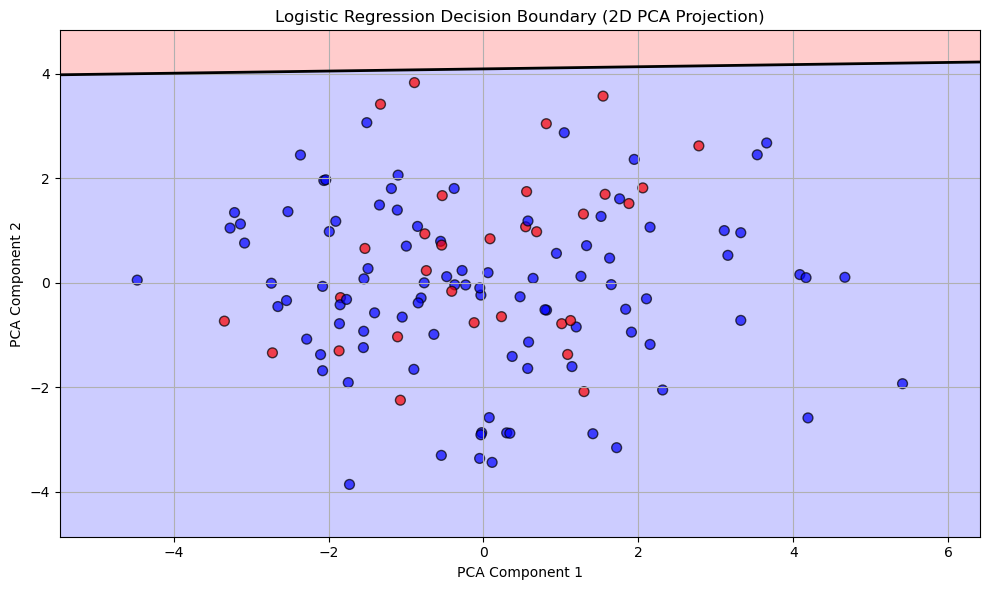

In [23]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import numpy as np

# === Step 1: Reduce to 2D with PCA ===
pca_2d = PCA(n_components=2)
X_train_pca_2d = pca_2d.fit_transform(X_train_scaled)

# === Step 2: Train Logistic Regression on 2D PCA data ===
logreg_2d = LogisticRegression(
    penalty='elasticnet',
    solver='saga',
    max_iter=10000,
    C=grid.best_params_['C'],
    l1_ratio=grid.best_params_['l1_ratio'],
    class_weight=grid.best_params_['class_weight']
)
logreg_2d.fit(X_train_pca_2d, y_train)

# === Step 3: Create meshgrid ===
x_min, x_max = X_train_pca_2d[:, 0].min() - 1, X_train_pca_2d[:, 0].max() + 1
y_min, y_max = X_train_pca_2d[:, 1].min() - 1, X_train_pca_2d[:, 1].max() + 1
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)

# Predict probability for each point in mesh
grid_points = np.c_[xx.ravel(), yy.ravel()]
proba = logreg_2d.predict_proba(grid_points)[:, 1]
proba = proba.reshape(xx.shape)

# === Step 4: Plot ===
plt.figure(figsize=(10, 6))

# Contour for decision boundary at probability = 0.5
plt.contourf(xx, yy, proba, levels=[0, 0.5, 1], alpha=0.2, colors=["blue", "red"])
plt.contour(xx, yy, proba, levels=[0.5], colors='k', linewidths=2)

# Scatter actual data points
colors = ['blue' if label == 0 else 'red' for label in y_train]
plt.scatter(X_train_pca_2d[:, 0], X_train_pca_2d[:, 1], c=colors, edgecolor='k', s=50, alpha=0.7)

plt.title("Logistic Regression Decision Boundary (2D PCA Projection)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.tight_layout()
plt.grid(True)
plt.show()
